# Decision Trees - From Scratch



## 1. About this Sprint

### Objective
- Understand **decision trees** (from scratch)
- Get comfortable implementing a more complex algorithm
- Learn via **implement - train - validate**


In [2]:
# Imports & setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try scikit-learn for metrics and baseline; fall back to manual if not available
try:
    from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
    from sklearn.tree import DecisionTreeClassifier as SkDT
    SKLEARN_AVAILABLE = True
except Exception:
    SKLEARN_AVAILABLE = False

np.random.seed(42)

# Matplotlib default/pref params
plt.rcParams["figure.figsize"] = (7.5, 5.0)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 11

print("scikit-learn available:", SKLEARN_AVAILABLE)

scikit-learn available: True


## 2. Core Metrics

### Problem 1 - Gini Impurity Function


In [3]:
def gini_from_counts(counts):
    """
    Compute Gini impurity from class counts (1D array-like of non-negative integers).
    """
    counts = np.asarray(counts, dtype=float)
    total = counts.sum()
    if total <= 0:
        return 0.0
    p = counts / total
    return float(1.0 - np.sum(p**2))

# Checks from prompt examples
examples = [
    ([15, 15], 0.500),
    ([15, 15, 15], 0.667),  # approx
    ([18, 12], 0.480),
    ([30, 0], 0.000),
]

for counts, ref in examples:
    val = gini_from_counts(counts)
    print(f"counts={counts} -> gini={val:.3f} (ref {ref})")

counts=[15, 15] -> gini=0.500 (ref 0.5)
counts=[15, 15, 15] -> gini=0.667 (ref 0.667)
counts=[18, 12] -> gini=0.480 (ref 0.48)
counts=[30, 0] -> gini=0.000 (ref 0.0)


### Problem 2 - Information Gain Function


In [4]:
def information_gain_from_counts(parent_counts, left_counts, right_counts):
    """
    Compute information gain from class counts in parent/left/right nodes.
    """
    parent_counts = np.asarray(parent_counts, dtype=float)
    left_counts = np.asarray(left_counts, dtype=float)
    right_counts = np.asarray(right_counts, dtype=float)

    n_p = parent_counts.sum()
    n_l = left_counts.sum()
    n_r = right_counts.sum()
    if n_p <= 0:
        return 0.0

    I_p = gini_from_counts(parent_counts)
    I_l = gini_from_counts(left_counts)
    I_r = gini_from_counts(right_counts)

    return float(I_p - (n_l / n_p) * I_l - (n_r / n_p) * I_r)

# Check from prompt example:
# Left: class1=10, class2=30 ; Right: class1=20, class2=5  -> IG ≈ 0.143
left_counts = [10, 30]
right_counts = [20, 5]
parent_counts = (np.array(left_counts) + np.array(right_counts)).tolist()
ig = information_gain_from_counts(parent_counts, left_counts, right_counts)
print(f"IG test -> {ig:.3f} (ref 0.143)")

IG test -> 0.143 (ref 0.143)


### Utilities for Splitting

- We consider thresholds at **midpoints** between sorted unique values (like scikit-learn).
- For each feature and threshold, we compute class counts on left/right and evaluate **information gain**.

In [5]:
def class_counts(y):
    """Return counts per unique class in ascending order of class labels, plus the label order."""
    labels, counts = np.unique(y, return_counts=True)
    return counts, labels

def split_by_threshold(X_col, thr):
    """Return boolean mask for left branch (X_col < thr)."""
    return X_col < thr

def candidate_thresholds_from_column(col):
    """Midpoints between sorted unique values."""
    vals = np.unique(col)
    if len(vals) <= 1:
        return []
    mids = (vals[:-1] + vals[1:]) / 2.0
    return mids.tolist()

## 3. Depth-1 Decision Tree (Decision Stump)


In [6]:
class ScratchDecesionTreeClassifierDepth1:
    """
    Scratch implementation of a depth-1 decision tree classifier (decision stump).
    """

    def __init__(self, verbose=False):
        self.verbose = bool(verbose)
        # learned parameters
        self.feature_index_ = None
        self.threshold_ = None
        self.left_class_ = None
        self.right_class_ = None
        self.root_class_ = None  # used if no split

        # helpers
        self.classes_ = None

    def _majority_class(self, y):
        labels, counts = np.unique(y, return_counts=True)
        return labels[np.argmax(counts)]

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y)
        n_samples, n_features = X.shape
        self.classes_ = np.unique(y)

        # Root majority (fallback)
        self.root_class_ = self._majority_class(y)

        # Parent impurity
        parent_counts, _ = class_counts(y)
        best_ig = -np.inf
        best_feat = None
        best_thr = None
        best_left_class = None
        best_right_class = None

        for j in range(n_features):
            thresholds = candidate_thresholds_from_column(X[:, j])
            for thr in thresholds:
                left_mask = split_by_threshold(X[:, j], thr)
                right_mask = ~left_mask
                if not left_mask.any() or not right_mask.any():
                    continue
                y_left = y[left_mask]
                y_right = y[right_mask]
                left_counts, _ = class_counts(y_left)
                right_counts, _ = class_counts(y_right)
                ig = information_gain_from_counts(parent_counts, left_counts, right_counts)
                if ig > best_ig:
                    best_ig = ig
                    best_feat = j
                    best_thr = thr
                    best_left_class = self._majority_class(y_left)
                    best_right_class = self._majority_class(y_right)

        if best_feat is None or best_ig <= 1e-12:
            # no effective split
            if self.verbose:
                print("No effective split; using root majority class.")
            self.feature_index_ = None
            self.threshold_ = None
            self.left_class_ = None
            self.right_class_ = None
        else:
            self.feature_index_ = best_feat
            self.threshold_ = best_thr
            self.left_class_ = best_left_class
            self.right_class_ = best_right_class
            if self.verbose:
                print(f"Best split: feature {best_feat}, threshold {best_thr:.4f}, IG={best_ig:.6f}")

        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        if self.feature_index_ is None:
            # single leaf
            return np.full(X.shape[0], self.root_class_, dtype=self.classes_.dtype)
        mask_left = split_by_threshold(X[:, self.feature_index_], self.threshold_)
        y_hat = np.empty(X.shape[0], dtype=self.classes_.dtype)
        y_hat[mask_left] = self.left_class_
        y_hat[~mask_left] = self.right_class_
        return y_hat

## 4. Verification - Training & Estimation (Problem 5)

Use the **housing dataset**
We compare with scikit-learn’s `DecisionTreeClassifier(max_depth=1)` and report **Accuracy / Precision / Recall**.

In [7]:
from sklearn.model_selection import train_test_split

# Load House Prices and build a binary label
def load_house_prices_binary(
    path="/content/train.csv", # path to data file
    features=("GrLivArea", "YearBuilt"),
    target="SalePrice",
    threshold="median",
):
    df = pd.read_csv(path)
    # Keep only needed columns; drop rows with missing values
    cols = list(features) + [target]
    df = df[cols].dropna().copy()

    # Compute threshold
    if isinstance(threshold, str):
        if threshold.lower() == "median":
            tval = float(df[target].median())
        elif threshold.lower().startswith("q"):
            q = float(threshold[1:])
            tval = float(df[target].quantile(q))
        else:
            raise ValueError("threshold must be 'median', 'q<fract>' (e.g., 'q0.75'), or a number")
    else:
        tval = float(threshold)

    # Binary label: 1 if SalePrice >= tval else 0
    y = (df[target].values >= tval).astype(int)
    X = df[list(features)].values.astype(float)
    return X, y, tval, list(features)

# Use GrLivArea & YearBuilt; label = 1 if SalePrice >= median
X, y, used_thresh, feat_names = load_house_prices_binary(
    path="/content/train.csv",
    features=("GrLivArea", "YearBuilt"),
    target="SalePrice",
    threshold="median",
)
print(f"Loaded House Prices. X shape: {X.shape}, features: {feat_names}")
print(f"Classification threshold on SalePrice: {used_thresh:,.0f}")
print("Class balance (0,1):", np.bincount(y))

# Stratified train/validation split (70/30)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

# Train scratch decision tree (depth=1)
stump = ScratchDecesionTreeClassifierDepth1(verbose=True)
stump.fit(X_train, y_train)
y_pred_val = stump.predict(X_val)

# Metrics (scratch)
acc = accuracy_score(y_val, y_pred_val)
prec = precision_score(y_val, y_pred_val, zero_division=0)
rec = recall_score(y_val, y_pred_val, zero_division=0)
cm = confusion_matrix(y_val, y_pred_val)

print("\nScratch Depth-1 — Validation")
print("  Accuracy :", f"{acc:.4f}")
print("  Precision:", f"{prec:.4f}")
print("  Recall   :", f"{rec:.4f}")
print("Confusion Matrix:\n", cm)

# Baseline: sklearn DecisionTreeClassifier (max_depth=1)
sk = SkDT(max_depth=1, random_state=42)
sk.fit(X_train, y_train)
y_pred_val_sk = sk.predict(X_val)

acc2  = accuracy_score(y_val, y_pred_val_sk)
prec2 = precision_score(y_val, y_pred_val_sk, zero_division=0)
rec2  = recall_score(y_val, y_pred_val_sk, zero_division=0)
cm2   = confusion_matrix(y_val, y_pred_val_sk)

print("\nscikit-learn DecisionTreeClassifier (max_depth=1) — Validation")
print("  Accuracy :", f"{acc2:.4f}")
print("  Precision:", f"{prec2:.4f}")
print("  Recall   :", f"{rec2:.4f}")
print("Confusion Matrix:\n", cm2)

Loaded House Prices. X shape: (1460, 2), features: ['GrLivArea', 'YearBuilt']
Classification threshold on SalePrice: 163,000
Class balance (0,1): [728 732]
Best split: feature 1, threshold 1984.5000, IG=0.201134

Scratch Depth-1 — Validation
  Accuracy : 0.8105
  Precision: 0.8827
  Recall   : 0.7182
Confusion Matrix:
 [[197  21]
 [ 62 158]]

scikit-learn DecisionTreeClassifier (max_depth=1) — Validation
  Accuracy : 0.8105
  Precision: 0.8827
  Recall   : 0.7182
Confusion Matrix:
 [[197  21]
 [ 62 158]]


Very interesting! Similar performance from both models.

## Problem 6 - Decision Region Visualization

We visualize the 2D decision regions learned by the **depth-1** tree and overlay training points.

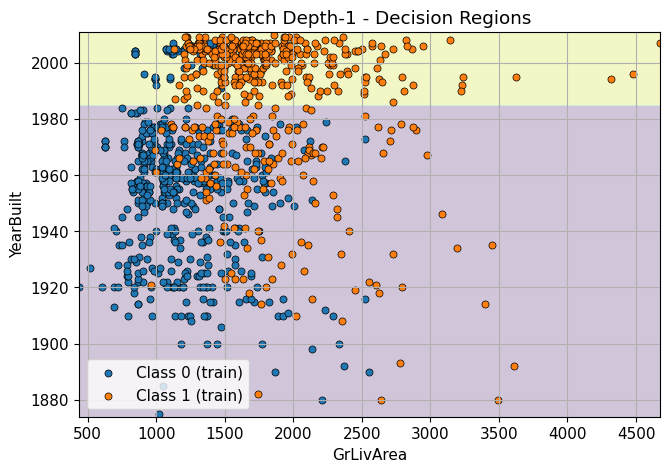

In [9]:
def plot_decision_regions(model, X_train, y_train, title="Decision Regions", feature_names=None):
    """
    Plots decision regions for a 2D classifier.
    - model: fitted model with .predict
    - X_train: (n,2) training features (original space)
    - y_train: (n,) labels in {0,1}
    - feature_names: optional list/tuple of two names for x/y axes
    """
    # Use training data for plot bounds
    x_min, x_max = X_train[:, 0].min() - 1.0, X_train[:, 0].max() + 1.0
    y_min, y_max = X_train[:, 1].min() - 1.0, X_train[:, 1].max() + 1.0

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    fig = plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.25)

    # Training points with labels
    plt.scatter(
        X_train[y_train == 0, 0], X_train[y_train == 0, 1],
        s=26, edgecolor="k", linewidth=0.5, label="Class 0 (train)"
    )
    plt.scatter(
        X_train[y_train == 1, 0], X_train[y_train == 1, 1],
        s=26, edgecolor="k", linewidth=0.5, label="Class 1 (train)"
    )

    # Axis labels
    xlab = feature_names[0] if feature_names else "x1"
    ylab = feature_names[1] if feature_names else "x2"
    plt.xlabel(xlab)
    plt.ylabel(ylab)

    plt.title(title)
    plt.legend()
    plt.show()

# Example call (with real feature names if you have them)
plot_decision_regions(
    stump, X_train, y_train,
    title="Scratch Depth-1 - Decision Regions",
    feature_names=["GrLivArea", "YearBuilt"]  # or omit to use x1/x2
)

## 5. Deeper Decision Trees

### Problem 7 - Depth 2 Classifier
### Problem 8 - Arbitrary Depth (until perfect purity or `max_depth`)

In [10]:
class _DTNode:
    def __init__(self, depth=0):
        self.depth = depth
        self.is_leaf = False
        self.pred_class = None
        self.feature_index = None
        self.threshold = None
        self.left = None
        self.right = None

class ScratchDecesionTreeClassifierDepthInf:
    """
    Generic CART-style decision tree (binary splits) with a max_depth cap.
    Stops when:
      - depth == max_depth, or
      - gini == 0 (pure), or
      - no split improves information gain.
    """

    def __init__(self, max_depth=None, min_samples_split=2, verbose=False):
        self.max_depth = max_depth
        self.min_samples_split = int(min_samples_split)
        self.verbose = bool(verbose)
        self.root_ = None
        self.classes_ = None

    def _majority_class(self, y):
        labels, counts = np.unique(y, return_counts=True)
        return labels[np.argmax(counts)]

    def _best_split(self, X, y):
        parent_counts, _ = class_counts(y)
        best_ig = -np.inf
        best_feat = None
        best_thr = None
        best_masks = None

        n_features = X.shape[1]
        for j in range(n_features):
            thresholds = candidate_thresholds_from_column(X[:, j])
            for thr in thresholds:
                left_mask = split_by_threshold(X[:, j], thr)
                right_mask = ~left_mask
                if left_mask.sum() < 1 or right_mask.sum() < 1:
                    continue
                left_counts, _ = class_counts(y[left_mask])
                right_counts, _ = class_counts(y[right_mask])
                ig = information_gain_from_counts(parent_counts, left_counts, right_counts)
                if ig > best_ig:
                    best_ig = ig
                    best_feat = j
                    best_thr = thr
                    best_masks = (left_mask, right_mask)
        return best_ig, best_feat, best_thr, best_masks

    def _build(self, X, y, depth):
        node = _DTNode(depth=depth)
        # stopping conditions
        counts, _ = class_counts(y)
        g = gini_from_counts(counts)
        if self.max_depth is not None and depth >= self.max_depth:
            node.is_leaf = True
            node.pred_class = self._majority_class(y)
            return node
        if g <= 0.0 or X.shape[0] < self.min_samples_split:
            node.is_leaf = True
            node.pred_class = self._majority_class(y)
            return node

        ig, feat, thr, masks = self._best_split(X, y)
        if feat is None or ig <= 1e-12:
            node.is_leaf = True
            node.pred_class = self._majority_class(y)
            return node

        left_mask, right_mask = masks
        node.feature_index = feat
        node.threshold = thr
        node.left = self._build(X[left_mask], y[left_mask], depth+1)
        node.right = self._build(X[right_mask], y[right_mask], depth+1)
        return node

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y)
        self.classes_ = np.unique(y)
        self.root_ = self._build(X, y, depth=0)
        if self.verbose:
            print("Tree built.")

    def _predict_one(self, x):
        node = self.root_
        while not node.is_leaf:
            if x[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.pred_class

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        return np.array([self._predict_one(x) for x in X], dtype=self.classes_.dtype)

class ScratchDecesionTreeClassifierDepth2(ScratchDecesionTreeClassifierDepthInf):
    def __init__(self, verbose=False):
        super().__init__(max_depth=2, verbose=verbose)

# depth-1 wrapper from generic (for parity)
class ScratchDecesionTreeClassifierDepth1_General(ScratchDecesionTreeClassifierDepthInf):
    def __init__(self, verbose=False):
        super().__init__(max_depth=1, verbose=verbose)

### Train Depth-2 and Depth-∞ (until purity or no gain)


Depth-2: Acc=0.8356  Prec=0.9512  Rec=0.7091
Depth-Inf: Acc=0.8470  Prec=0.8626  Rec=0.8273


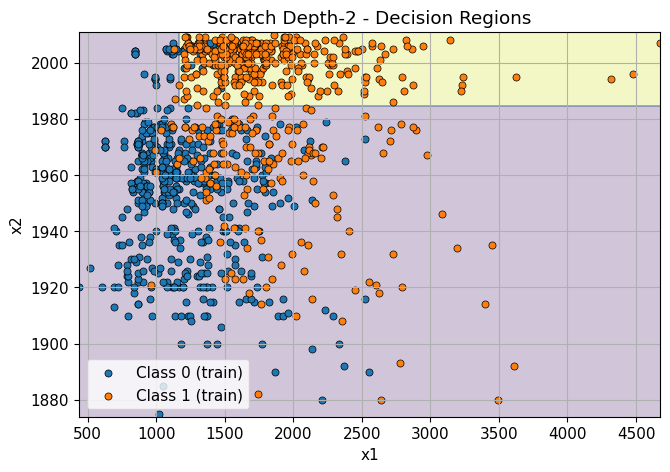

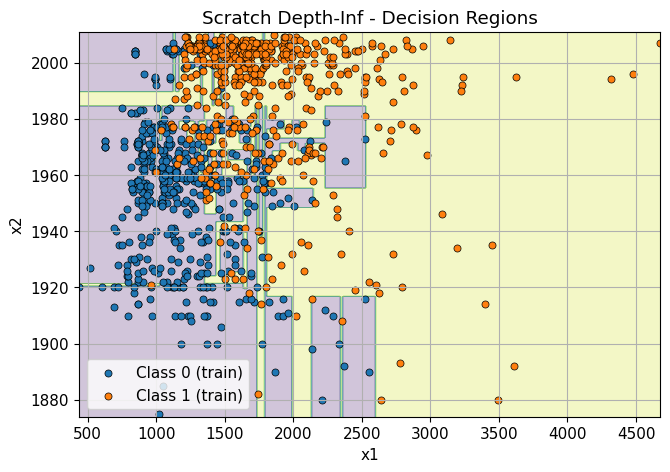

In [12]:
tree2 = ScratchDecesionTreeClassifierDepth2(verbose=False)
tree2.fit(X_train, y_train)
pred2 = tree2.predict(X_val)

tree_inf = ScratchDecesionTreeClassifierDepthInf(max_depth=None, verbose=False)
tree_inf.fit(X_train, y_train)
pred_inf = tree_inf.predict(X_val)

def report_metrics(name, y_true, y_pred):
    if SKLEARN_AVAILABLE:
        a = accuracy_score(y_true, y_pred)
        p = precision_score(y_true, y_pred)
        r = recall_score(y_true, y_pred)
    else:
        a = float((y_true == y_pred).mean())
        tp = np.sum((y_true==1)&(y_pred==1)); fp = np.sum((y_true==0)&(y_pred==1)); fn = np.sum((y_true==1)&(y_pred==0))
        p = float(tp/(tp+fp+1e-12)); r = float(tp/(tp+fn+1e-12))
    print(f"{name}: Acc={a:.4f}  Prec={p:.4f}  Rec={r:.4f}")

report_metrics("Depth-2", y_val, pred2)
report_metrics("Depth-Inf", y_val, pred_inf)

# Visualize regions
plot_decision_regions(tree2, X_train, y_train, title="Scratch Depth-2 - Decision Regions")
plot_decision_regions(tree_inf, X_train, y_train, title="Scratch Depth-Inf - Decision Regions")